# HMM PoS tagger

## Corpus

**The Georgetown University Multilayer Corpus (GUM) is an open source multilayer corpus of richly annotated texts from 16 text types.**

- https://gucorpling.org/gum/

- Zeldes, Amir (2017) "The GUM Corpus: Creating Multilayer Resources in the Classroom". Language Resources and Evaluation 51(3), 581–612. https://link.springer.com/article/10.1007/s10579-016-9343-x

- https://github.com/UniversalDependencies/UD_English-GUM/blob/master/README.md


**A Genre-Diverse Multilayer Challenge Set for English NLP and Linguistic Evaluation (GENTLE) is a manually annotated multilayer corpus following the same design and annotation layers as GUM, but of unusual text types.**

- https://gucorpling.org/gum/gentle.html

- Aoyama, Tatsuya, Behzad, Shabnam, Gessler, Luke, Levine, Lauren, Lin, Jessica, Liu, Yang Janet, Peng, Siyao, Zhu, Yilun and Zeldes, Amir (2023) "GENTLE: A Genre-Diverse Multilayer Challenge Set for English NLP and Linguistic Evaluation". In: Proceedings of the Seventeenth Linguistic Annotation Workshop (LAW-XVII 2023). Toronto, Canada. https://arxiv.org/abs/2306.01966

- https://github.com/UniversalDependencies/UD_English-GENTLE/blob/master/README.md

### PoS Tags

There are 17 unique PoS Tags in the datasets. In the following code chunk the number of tokens per tag is shown followed by the most common lemmas. However, GUM's stats file presents some incosistences regarding the number of tokens per tag (as our algorithm recovers correctly these numbers for the GENTLE case, but are some minimal differences with GUM, we believe the stats file of the repo is wrong). 

It is worth mentioning that exists a _ tag that should be avoided like the following example:

- 12-13	workforce’s	_	_	_	_	_	_	_	_

- 12	workforce	workforce	NOUN	NN	Number=Sing	14	nmod:poss	14:nmod:poss	_

- 13	’s	's	PART	POS	_	12	case	12:case	Entity=42)

In [ ]:
""" https://github.com/UniversalDependencies/UD_English-GUM/blob/master/stats.xml
<!-- Statistics of universal POS tags. The comments show the most frequent lemmas. -->
<tags unique="17">
<tag name="ADJ">13961</tag><!-- good, other, first, new, many, great, little, large, more, different -->
<tag name="ADP">20170</tag><!-- of, in, to, for, on, with, at, from, by, as -->
<tag name="ADV">10103</tag><!-- so, when, just, then, also, how, now, more, here, really -->
<tag name="AUX">11355</tag><!-- be, have, do, can, will, would, should, could, may, might -->
<tag name="CCONJ">7057</tag><!-- and, or, but, both, &, either, nor, yet, neither, plus -->
<tag name="DET">17331</tag><!-- the, a, this, all, that, some, no, any, every, another -->
<tag name="INTJ">2023</tag><!-- like, yeah, oh, well, so, um, uh, no, okay, yes -->
<tag name="NOUN">35507</tag><!-- person, time, year, day, thing, way, life, city, world, work -->
<tag name="NUM">3994</tag><!-- one, two, 1, three, 2, 3, four, 4, five, 10 -->
<tag name="PART">5113</tag><!-- to, not, 's -->
<tag name="PRON">17819</tag><!-- I, it, you, we, that, they, he, his, this, your -->
<tag name="PROPN">12184</tag><!-- State, President, University, America, York, New, Warhol, Figure, American, south -->
<tag name="PUNCT">28955</tag><!-- ,, ., '', -, ?, (, ), —, [, : -->
<tag name="SCONJ">3393</tag><!-- that, if, as, because, for, of, by, while, in, after -->
<tag name="SYM">317</tag><!-- -, /, $, %, +, =, DKK, €, £, § -->
<tag name="VERB">22277</tag><!-- have, know, go, make, do, get, say, be, take, think -->
<tag name="X">361</tag><!-- _, et, al., de, 1, 1., 2., in, situ, 2 -->
</tags>
"""

""" https://github.com/UniversalDependencies/UD_English-GENTLE/blob/master/stats.xml
<!-- Statistics of universal POS tags. The comments show the most frequent lemmas. -->
<tags unique="17">
<tag name="ADJ">1240</tag><!-- next, other, first, old, open, more, good, straight, chronic, right -->
<tag name="ADP">1588</tag><!-- of, in, to, for, with, on, from, by, at, as -->
<tag name="ADV">729</tag><!-- then, just, so, well, here, also, thus, how, where, now -->
<tag name="AUX">753</tag><!-- be, will, have, can, do, would, may, should, could, shall -->
<tag name="CCONJ">618</tag><!-- and, or, but, &, either, /, plus, yet, both, neither -->
<tag name="DET">1195</tag><!-- the, a, this, all, no, any, that, some, each, every -->
<tag name="INTJ">60</tag><!-- fucking, please, ah, well, oh, okay, so, uh, ha, now -->
<tag name="NOUN">3783</tag><!-- week, x, T, project, school, S, person, day, time, y -->
<tag name="NUM">386</tag><!-- one, 1, 5, 2, two, 4, 3, X, 10, three -->
<tag name="PART">349</tag><!-- to, not, 's -->
<tag name="PRON">1188</tag><!-- I, you, he, it, we, his, that, my, your, they -->
<tag name="PROPN">901</tag><!-- Company, JavaScript, Book, Proposition, Court, English, Week, Career, React, Agreement -->
<tag name="PUNCT">2655</tag><!-- ,, ., :, '', (, ), -, ;, —, ! -->
<tag name="SCONJ">234</tag><!-- that, if, as, because, in, by, like, of, while, before -->
<tag name="SYM">167</tag><!-- ⪯, ∈, =, -, ⋅, /, %, +, $, ≤ -->
<tag name="VERB">1653</tag><!-- have, go, do, get, take, see, follow, make, know, let -->
<tag name="X">300</tag><!-- 1., 2., 3., 4., 5., 6., 7., 8., 9., 10. -->
</tags>
"""

PoS_tags = [
    ("ADJ", 12348, 1621, 1240),
    ("ADP", 17702, 2481, 1588),
    ("ADV", 8989, 1115, 729),
    ("AUX", 10174, 1189, 753),
    ("CCONJ", 6218, 839, 618),
    ("DET", 15224, 2111, 1195),
    ("INTJ", 1859, 164, 60),
    ("NOUN", 31274, 4240, 3783),
    ("NUM", 3554, 440, 386),
    ("PART", 4595, 519, 349),
    ("PRON", 16077, 1746, 1188),
    ("PROPN", 10557, 1627, 901),
    ("PUNCT", 25928, 3027, 2655),
    ("SCONJ", 3053, 340, 234),
    ("SYM", 282, 35, 167),
    ("VERB", 19865, 2479, 1653),
    ("X", 329, 32, 300),
]

### Document type

Documents come from a wide variety of sources. In order to group them in an efficient way, those documents belonging to same area are gathered together. 

For instance, GUM_academic_art, GUM_academic_census... will belong to GUM_academic. 

In the following code block, each distinction is shown.

In [ ]:
# https://github.com/UniversalDependencies/UD_English-GUM/tree/master/not-to-release/sources

doc_type_GUM = [
    "GUM_academic",
    "GUM_bio",
    "GUM_conversation",
    "GUM_court",
    "GUM_essay",
    "GUM_fiction",
    "GUM_interview",
    "GUM_letter",
    "GUM_news",
    "GUM_podcast",
    "GUM_speech",
    "GUM_textbook",
    "GUM_vlog",
    "GUM_voyage",
    "GUM_whow",
]

# https://github.com/UniversalDependencies/UD_English-GENTLE/tree/master/not-to-release/sources

doc_type_GENTLE = [
    "GENTLE_dictionary",
    "GENTLE_esports",
    "GENTLE_legal",
    "GENTLE_medical",
    "GENTLE_poetry",
    "GENTLE_proof",
    "GENTLE_syllabus",
    "GENTLE_threat",
]

## HMM implementation

In [ ]:
%pip install conllu
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install json
%pip install requests
%pip install BeautifulSoup

In [ ]:
import os
from conllu import parse_incr
from typing import Dict, List, Tuple
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
import requests
import BeautifulSoup as bs

To implement the HMM model, we will follow these steps:

- Initialize the model with three parameters:
    path_data: The directory where all necessary data is stored.
    lemmatize: A flag indicating whether the model should lemmatize the tokens.
    threshold: A percentage threshold that determines which words are kept in the vocabulary. Remaining words will be replaced with the UNK token.

- Prepare the training and testing datasets and verify that the number of tokens per document is correct. For each partition, the data will be stored in a Dict[str, List[List[Tuple[str, str]]]] structure, in which for each document type (key of the Dict) each sentence is a list of tuples in the form (word/lemma, PoS tag).

- To create the vocabulary for the model, we will use only the training dataset to calculate the frequency of each word/lemma. These words/lemmas will be sorted in descending order by frequency. Using the previously set threshold, we will determine the cutoff point for the vocabulary percentage. All words/lemmas above this threshold will be retained in the vocabulary, while the rest will be discarded (and, therefore, considered as UNK). 

- Finally, the emission and transition matrices of the Hidden Markov Model will be calculated. To do this, the following matrices will be computed using the training dataset and then smoothed using Laplace smoothing. Moreover, log probabilities will be used to prevent underflow.

$$ 

\sum_{i=1}^{n} \log \left( \frac{\text{count}(y_{i-1}, y_i) + 1}{\text{count}(y_{i-1}) + |Y|} \right) \quad \text{(Transition)}



+ \sum_{i=1}^{n} \log \left( \frac{\text{count}(y_i, x_i) + 1}{\text{count}(y_i) + |X|} \right) \quad \text{(Emission) }

\\
\text{where } \quad y \text{ is the PoS tag} \quad x \text{ is the word/lemma, } \\
\quad |X| \text{ is the size of the vocabulary, and } \quad |Y| \text{ is the number of tags.}

$$

In [ ]:
# Implementation of the HMM model
class HMM_PoS_tagger:
    def __init__(self, path_data: str, lemmatize: bool, threshold: float):
        self.path_data = path_data
        self.lemmatize = lemmatize
        self.threshold = threshold
        self.counter = Counter()  # 12770 unique tokens in train, 188028 total tokens
        # Read data from train and test datasets & check that is correct
        self.train = self.read_train_data()
        self.test_GUM = self.read_test_data(is_GUM=True)
        self.test_GENTLE = self.read_test_data(is_GUM=False)
        # Create vocabulary
        self.vocab = self.create_vocab()
        # Add UNK token to the vocabulary
        self.vocab = ["UNK"] + self.vocab
        # Add START and STOP tags to the tags
        self.tags = ["START", "STOP"] + [x[0] for x in PoS_tags]
        # Train the model and get the emission and transition matrices
        self.emission, self.transition = self.train_model()

    def read_train_data(self) -> Dict[str, List[List[Tuple[str, str]]]]:

        # Train and Dev datasets will be used to train the model
        paths = [
            os.path.join(self.path_data, "en_gum-ud-train.conllu"),
            os.path.join(self.path_data, "en_gum-ud-dev.conllu"),
        ]

        data = self.read_data(paths)

        # Check that number of sentences and tokens per tag are correct
        # Also, update the vocabulary for future processing
        tags_counter = Counter()
        cont_sentences = 0
        for sentences in data.values():
            cont_sentences += len(sentences)
            for sentence in sentences:
                for tok, tag in sentence:
                    tags_counter.update([tag])
                    self.counter.update([tok])

        # Number of sentences is correct
        assert cont_sentences == 9520 + 1341
        # Document types are correct
        assert list(data.keys()) == doc_type_GUM
        # Number of tokens per tag is correct
        assert [(x[0], x[-3]) for x in PoS_tags] == sorted(tags_counter.items())
        return data

    def read_test_data(self, is_GUM: bool) -> Dict[str, List[List[Tuple[str, str]]]]:

        # Both GUM and GENTLE test datasets will be used to evaluate the model
        path = (
            os.path.join(self.path_data, "en_gum-ud-test.conllu")
            if is_GUM
            else os.path.join(self.path_data, "en_gentle-ud-test.conllu")
        )

        data = self.read_data([path])

        # Check that number of sentences and tokens per tag are correct
        cont_sentences = 0
        tags_counter = Counter()

        for sentences in data.values():
            cont_sentences += len(sentences)
            for sentence in sentences:
                for _, tag in sentence:
                    tags_counter.update([tag])

        if is_GUM:
            # Number of sentences is correct
            assert cont_sentences == 1285
            # Document types are correct
            assert list(data.keys()) == doc_type_GUM
            # Number of tokens per tag is correct
            assert [(x[0], x[-2]) for x in PoS_tags] == sorted(tags_counter.items())
        else:
            # Number of sentences is correct
            assert cont_sentences == 1334
            # Document types are correct
            assert list(data.keys()) == doc_type_GENTLE
            # Number of tokens per tag is correct
            assert [(x[0], x[-1]) for x in PoS_tags] == sorted(tags_counter.items())

        return data

    def read_data(self, paths: list[str]) -> Dict[str, List[List[Tuple[str, str]]]]:
        data = {}
        for path in paths:
            assert os.path.exists(path), f"The {path} path does not exist"
            # Name of the read last document type
            last_doc_id = ""
            with open(path, "r", encoding="utf-8") as file:
                for tokenlist in parse_incr(file):
                    if "newdoc id" in tokenlist.metadata:
                        # Get the document type and remove unnecessary additional information
                        doc_type = "_".join(
                            tokenlist.metadata["newdoc id"].split("_")[:2]
                        )
                        # Avoid the first case ("") and change of document type if new is found
                        if doc_type != last_doc_id:
                            last_doc_id = doc_type

                    # Auxiliar list to store in Tuples the tokens and tags of the sentence
                    auxiliar = []
                    for token in tokenlist:
                        # Token has the following internal structure:
                        # token: <class 'conllu.models.Token'> /// dict_keys(['id', 'form', 'lemma', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])

                        # Avoid _ case as previously explained
                        if token["upos"] == "_":
                            continue
                        # Possibility to use the lemma or the form of the token
                        auxiliar.append(
                            (
                                token["lemma" if self.lemmatize else "form"].lower(),
                                token["upos"],
                            )
                        )

                    # If the document type is already in the dictionary, append the new data, otherwise, create a new key
                    if doc_type in data:
                        data[doc_type].append(auxiliar)
                    else:
                        data[doc_type] = [auxiliar]
        return data

    def create_vocab(self) -> List[str]:
        # Get the most common tokens in the train dataset
        tokens, times = zip(*self.counter.most_common())
        tokens = np.array(tokens)
        times = np.array(times)

        # Calculate the index of the tokens that are necessary to reach the threshold
        cum_times = np.cumsum(times)
        total_tokens = cum_times[-1]
        idx = np.searchsorted(cum_times, self.threshold * total_tokens)

        return tokens[: idx + 1].tolist()

    def train_model(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        emission = pd.DataFrame(
            np.zeros((len(self.tags), len(self.vocab)), dtype=np.float64),
            columns=self.vocab,
            index=self.tags,
        )
        transition = pd.DataFrame(
            np.zeros((len(self.tags), len(self.tags)), dtype=np.float64),
            columns=self.tags,
            index=self.tags,
        )

        for sentences in self.train.values():
            previous_tag = "START"
            for sentence in sentences:
                for tok, tag in sentence:
                    if tok not in self.vocab:
                        tok = "UNK"
                    emission.loc[tag, tok] += 1
                    transition.loc[previous_tag, tag] += 1
                    previous_tag = tag
                transition.loc[previous_tag, "STOP"] += 1

        ###############################################################################
        ################################ EMISSION #####################################
        ###############################################################################

        row_sums = emission.sum(axis=1)
        # Convert row_sums to a numpy array otherwise muldimensional indexing error
        row_sums = np.array(row_sums)

        # Considering alpha = 1 for smoothing
        #'''
        emission = np.log2(emission + 1) - np.log2(
            row_sums[:, np.newaxis] + len(self.vocab)
        )
        #'''

        """ Check that the sum of the rows is 1 as it is a probability distribution
        emission = (emission + 1) / (row_sums[:, np.newaxis] + len(self.vocab))
        row_sums_check = emission.sum(axis=1)
        assert np.allclose(row_sums_check, 1), f"Sums of rows must be 1"
        """

        ###############################################################################
        ################################ TRANSITION #################################
        ###############################################################################

        row_sums = transition.sum(axis=1)
        # Convert row_sums to a numpy array otherwise muldimensional indexing error
        row_sums = np.array(row_sums)

        # Considering alpha = 1 for smoothing
        #'''
        transition = np.log2(transition + 1) - np.log2(
            row_sums[:, np.newaxis] + len(self.tags)
        )
        #'''

        """ Check that the sum of the rows is 1 as it is a probability distribution
        transition = (transition + 1) / (row_sums[:, np.newaxis] + len(self.tags))
        row_sums_check = transition.sum(axis=1)
        assert np.allclose(row_sums_check, 1), f"Sums of rows must be 1"
        """

        ###############################################################################

        return emission, transition

In [ ]:
PATH_TO_REPO_FOLDER = input(
    "Enter the path to the repository folder (must end in HMM_PoS_Tagger): "
)

PATH_TO_DATA_FOLDER = os.path.join(PATH_TO_REPO_FOLDER, "data")
assert os.path.exists(
    PATH_TO_DATA_FOLDER
), f"The {PATH_TO_DATA_FOLDER} path does not exist"
LEMMATIZE = True
THRESHOLD = 0.9

tagger = HMM_PoS_tagger(path_data=PATH_TO_DATA_FOLDER, lemmatize=LEMMATIZE, threshold=THRESHOLD)

## Viterbi algorithm

The Viterbi algorithm is a dynamic programming method used to find the most probable sequence of states in a Hidden Markov Model (HMM), given a series of observations. The algorithm determines the most likely sequence of hidden states that generated the observed data.
Rather than enumerating all possible tag sequences, it leverages the Markov assumption in the HMM, which states that the probability of each state depends only on the previous one. The algorithm computes the most likely sequence of states by maximizing the joint probability of the observations and the states using a recursive process. This significantly reduces the computational complexity compared to exhaustively exploring all possible sequences.

Mathematically, it is represented as follows:

$$

\text{argmax}_{y \in Y} \prod_{i=1}^{n+1} p(y_i | y_{i-1}) \prod_{i=1}^{n} p(x_i | y_i)

$$


In [ ]:
# Implementation of the viterbi algorithm
def viterbi(sentence, init_matrix, transition_matrix, emission_matrix, word_to_index, category_to_index, index_to_category):
    sentence.insert(0, "START")
    #print(sentence)
    num_categories = len(init_matrix) # num categories N
    num_words = len(sentence) # num words in the sentence T

    # viterbi table
    viterbi_table = np.full((num_categories, num_words), -np.inf) # inf for logarithms
    backpointer_table = np.zeros((num_categories, num_words), dtype=int)


    # first step (init)
    for category in range(num_categories):
        #print("CATEGORY: ", index_to_category[category])
        #if index_to_category[category] == "START": 
        #    continue
        word_index = word_to_index.get(sentence[0], word_to_index["UNK"]) # we use UNK tag if the word is not in the vocab
        #result = init_matrix[category] + emission_matrix[category, word_index]
        result = init_matrix[category] + transition_matrix[category_to_index["START"], category]

        #print(result)
        viterbi_table[category, 0] = result # sum because of logs
    # print(viterbi_table)
        

    # recursion step
    for t in range (1, num_words): # from the 2nd to T
        for category in range(num_categories): # from 1 to N
            max_prob = -np.inf
            max_prev_category = 0
            word_index = word_to_index.get(sentence[t], word_to_index["UNK"])
            #print(sentence[t])

            for prev_category in range(num_categories):
                prev_viterbi = viterbi_table[prev_category, t-1]
                transition_score = transition_matrix[prev_category, category]
                '''
                if word_index is not None:
                    emission_score = emission_matrix[category, word_index]
                else:
                    emission_score = 0
                '''
                emission_score = emission_matrix[category, word_index]
                current_prob = prev_viterbi + transition_score + emission_score

                if current_prob > max_prob:
                    max_prob = current_prob
                    max_prev_category = prev_category

            # update tables viterbi and backpointer
            viterbi_table[category, t] = max_prob
            backpointer_table[category, t] = max_prev_category # a la que apunta 

    # final probability step
    max_final_category = np.argmax(viterbi_table[:, -1]) # all the rows of the last column
    max_prob = viterbi_table[max_final_category, -1] # maximum probability is the one in the last column of the max_final category row

    # construct optimal sequence
    optimal_seq = [max_final_category]
    for t in range(num_words-1, 0, -1): # from num_words-1 until 1, backward
        #print(t)
        back_value = backpointer_table[optimal_seq[0], t]
        optimal_seq.insert(0, back_value)

    optimal_tags = [index_to_category[idx] for idx in optimal_seq]
    
    return sentence[1:], optimal_tags[1:], max_prob


First, the input sentence is processed by adding a "START" token at the beginning to mark the start of the sequence. Then, two tables are initialized: the viterbi_table, which will store the accumulated probabilities of the most probable state sequences for each word, and the backpointer_table, which will store the indices of the previous states that led to those maximum probabilities.

The next step is the processing of the first word, the "START" token. For each category, the algorithm calculates the probability of the sequence starting in that category, based on the initial probability and the transition probability from the "START" state. This probability is stored in the viterbi_table, and the backpointer_table is updated with the state that led to the maximum probability.

The algorithm then enters the recursion step for the subsequent words. For each word in the sentence, and for each possible category, the algorithm calculates the probability of that category being the correct one for the current word, considering the accumulated probabilities from the previous states, the transition probabilities between categories, and the emission probabilities of the current word given the category. This probability is calculated as the sum of the probability of the previous state, the transition probability, and the emission probability. The viterbi_table is updated with the maximum probability, and the backpointer_table is adjusted to store the index of the previous state that leads to this maximum probability.

Once all words are processed, the algorithm moves to the final step, where it identifies the category with the maximum probability in the last step (the last word in the sentence). This category represents the most probable state at the end of the sequence.

Finally, the algorithm performs a traceback of the optimal category sequence using the backpointer_table. Starting from the state with the maximum probability at the final step, it traces backward through the time steps to reconstruct the most probable sequence of states.


The following code is a small test to ensure the correct functionality of the Viterbi algorithm. A new sentence is input into the algorithm, and the expected output is the most probable sequence of tags, along with the maximum log probability for the predicted sequence. 


In [ ]:
emission_matrix = tagger.emission
transition_matrix = tagger.transition

'''
print("Transition Matrix:")
print(transition_matrix)
print("Emission Matrix:")
print(emission_matrix)
'''

word_to_index = {word: idx for idx, word in enumerate(tagger.vocab)}
category_to_index = {tag: idx for idx, tag in enumerate(tagger.tags)}
index_to_category = {idx: tag for tag, idx in category_to_index.items()}

# Sentence to try
sentence1 = ["this", "is", "a", "test", "sentence"]
sentence2 = ["for", "another", "test", "sentence"]

sentence = sentence1


# initialize probs
num_categories = len(category_to_index)
init_matrix = np.full(num_categories, -np.inf)
init_matrix[category_to_index["START"]] = 0

# viterbi
checked_sentence, optimal_tags, max_prob = viterbi(
    sentence,
    init_matrix,
    transition_matrix.values,
    emission_matrix.values,
    word_to_index,
    category_to_index,
    index_to_category
)

print("Sentence:", checked_sentence)
print("Optimal Tags:", optimal_tags)
print("Max log probability:", max_prob)


# EXPERIMENTS

Rather than creating a very specific tool, the intention was to make
a model that is able to reliably perform in a wide variety of
categories. 

For this reason, our training corpus is quite big, and includes
data from very different sources. The expected result is for
our model to have as much accuracy on out-of-domain data as possible,
while maintaining a sufficient performance on in-domain data.

As we will see below, to test this hypothesis, we have chosen the GENTLE corpus,
made specifically of unusual text types including mathematical proofs and dictionary
entries, among others.

### In-domain

First of all, we need to define a function that evaluates our model.
We will tell this function which of our two test datasets (GUM or GENTLE)
to take to evaluate the model against, and a domain of said datasets.

The function will then print the precision and recall by tag, as well
as the total accuracy and the confusion matrix. The function should also
return the total number of mistakes and tokens, so we can more easily operate
with them.

In [ ]:
#This function calculates the precision and recall of our model
#for each tag for a given domain, as well as the total accuracy of our model
#where Acc = 100 - (100*NumMistakes/NumTokens)
def evaluate(isGUM: bool, domain: str, show_data:bool):

    #Check if the domain exists for the 2 corpuses we have been working with
    if isGUM:
        assert domain in doc_type_GUM, f"The domain {domain} is not in the GUM dataset"
        test = tagger.test_GUM[domain]
    else:
        assert (
            domain in doc_type_GENTLE
        ), f"The domain {domain} is not in the GENTLE dataset"
        test = tagger.test_GENTLE[domain]

    #list_gold contains all of the actual tags for each token
    #list_pred cointains the tags our model predicts
    list_gold, list_pred = [], []
    total_mistakes, total_tokens = 0, 0

    #Iterate through each of the sentences and then through each of the tokens
    #It's important to remember our data is stored in tuples (token, tag)
    for idx in range(len(test)):
        newSent = [tok for tok, _ in test[idx]]
        gold_tags = [tag for _, tag in test[idx]]
        total_tokens += len(newSent)
        list_gold.extend(gold_tags)

        checked_sentence, predicted_tags, _ = viterbi(
            newSent,
            init_matrix,
            transition_matrix.values,
            emission_matrix.values,
            word_to_index,
            category_to_index,
            index_to_category,
        )
        
        #Make sure the pre-processing of the data is correct by comparing lengths 
        assert ["START"] + checked_sentence == newSent, f"The sentence is not the same"
        assert len(gold_tags) == len(
            predicted_tags
        ), f"The length of the tokenized sentence and the predicted tags is not the same"
        list_pred.extend(predicted_tags)

        total_mistakes += sum(
            1 for pred, gold in zip(predicted_tags, gold_tags) if pred != gold
        )

    #print("Total number of mistakes: "  + str(total_mistakes))
    #print("% of mistakes: " + str(100 - (100 * total_mistakes / total_tokens)))

    if show_data == True:

        #Create and print the classification report using the sklearn library
        report = classification_report(list_gold, list_pred, zero_division=0, digits=4)
        print(report)


        #Create and print the confusion matrix. The confusion matrix looks very pretty (thanks, jon!)
        cm = confusion_matrix(list_gold, list_pred, labels=tagger.tags)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tagger.tags)
        fig, ax = plt.subplots(figsize=(20,20))

        disp.plot(ax=ax)

    return total_mistakes, total_tokens
    

Our model has two parameteres to tune it:

The threshold: How rare a word has to be to be tagged as "UNK". The higger this number, the less words
will be "UNK". As the corpus chosen to train this model is quite big (200k tokens), the initial assumption
is that this threshold will be quite high, for a lot of different words will naturally occur in train data.
As testing for every 1% increment would take way too long and very low numbers are expected to perform worse,
a small sample of the most likely to be the best thresholds has been manually chosen.

Lemmatization: Whether we are working with words or lemmas. If TRUE, the test data is also lemmatized.

In [92]:

#Keep into account that given the large amounts of data we are working with, executing this cell might take close to 30 minutes

thresholds = [0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
lemmatization = [False, True]

#max accuracy
accmax = 0
for threshold in thresholds:
    for lemma in lemmatization:

        #process the data with the given parameters
        tagger = HMM_PoS_tagger(path_data=PATH_TO_DATA_FOLDER, lemmatize=lemma, threshold=threshold)

        #variables to send the viterbi
        emission_matrix = tagger.emission
        transition_matrix = tagger.transition

        word_to_index = {word: idx for idx, word in enumerate(tagger.vocab)}
        category_to_index = {tag: idx for idx, tag in enumerate(tagger.tags)}
        index_to_category = {idx: tag for tag, idx in category_to_index.items()}

        # initialize probs
        num_categories = len(category_to_index)
        init_matrix = np.full(num_categories, -np.inf)
        init_matrix[category_to_index["START"]] = 0

        #total mistakes and tokens
        ttm = 0
        ttt = 0

        for domain in doc_type_GUM:

            #keep count of mistakes and tokens between domains to calculate accuracy
            tm, tt = evaluate(isGUM=True, domain=domain, show_data=False)
            ttm += tm
            ttt += tt

            #compare accuracy and save parameters that give the highest

        acc = (100 - (100 * (ttm/ttt)))
        if (acc > accmax):
            accmax = acc
            l = lemma
            t = threshold
            

print(l)
print(t)
print(accmax)

True
0.97
86.89023120183295


We get the best result when lemmatizing and using a threshold of 97% (that is, the 3% of less common lemmas is turned into UNK).
This model gives us an overall accuracy of 86.89%, which is quite good if we take into account how different the categories of our corpus were to each other.

Let's see how the different categories of GUM perform with this parameters:

In [93]:

for domain in doc_type_GUM:
    print("----------------------------------------------------------------------------------------------------")
    print(f"-------------------------------------------{domain}------------------------------------------------")
    print("----------------------------------------------------------------------------------------------------")
    mis, tok = evaluate(isGUM=True, domain=domain, show_data=False)
    print("The accuracy for " + str(domain) + " is: " + str(100-(100 * mis/tok)))
    print("####################################################################################################")
    print("####################################################################################################")


----------------------------------------------------------------------------------------------------
-------------------------------------------GUM_academic------------------------------------------------
----------------------------------------------------------------------------------------------------
The accuracy for GUM_academic is: 83.0005120327701
####################################################################################################
####################################################################################################
----------------------------------------------------------------------------------------------------
-------------------------------------------GUM_bio------------------------------------------------
----------------------------------------------------------------------------------------------------
The accuracy for GUM_bio is: 81.59618820726624
#############################################################################################

The best performing categories are Conversations (92.3%) and Vlogs (90.5%).
The worst performing categories are News(84,3%) and Biographies(84,5).

We could have probably gotten higher numbers for each of these categories had the model
been trained specifially for them. Let's now print the specifics of the data for the best
and worst perfoming domains, and then see whether this loss of accuracy paid off by checking
if our model is able to keep up with the purposely chosen for being hard to work with domains of GENTLE



              precision    recall  f1-score   support

         ADJ     0.7925    0.8750    0.8317        48
         ADP     0.8455    0.9720    0.9043       107
         ADV     0.8689    0.7571    0.8092       140
         AUX     0.9038    0.9216    0.9126       153
       CCONJ     1.0000    1.0000    1.0000        54
         DET     0.9333    0.9492    0.9412       118
        INTJ     0.8936    0.8235    0.8571       102
        NOUN     0.9141    0.9255    0.9198       161
         NUM     1.0000    0.9167    0.9565        12
        PART     0.9796    1.0000    0.9897        48
        PRON     0.9425    0.9866    0.9641       299
       PROPN     0.8571    0.2727    0.4138        22
       PUNCT     1.0000    1.0000    1.0000       365
       SCONJ     0.8889    0.6667    0.7619        24
        STOP     0.0000    0.0000    0.0000         0
        VERB     0.8698    0.8863    0.8779       211
           X     0.0000    0.0000    0.0000         4

    accuracy              

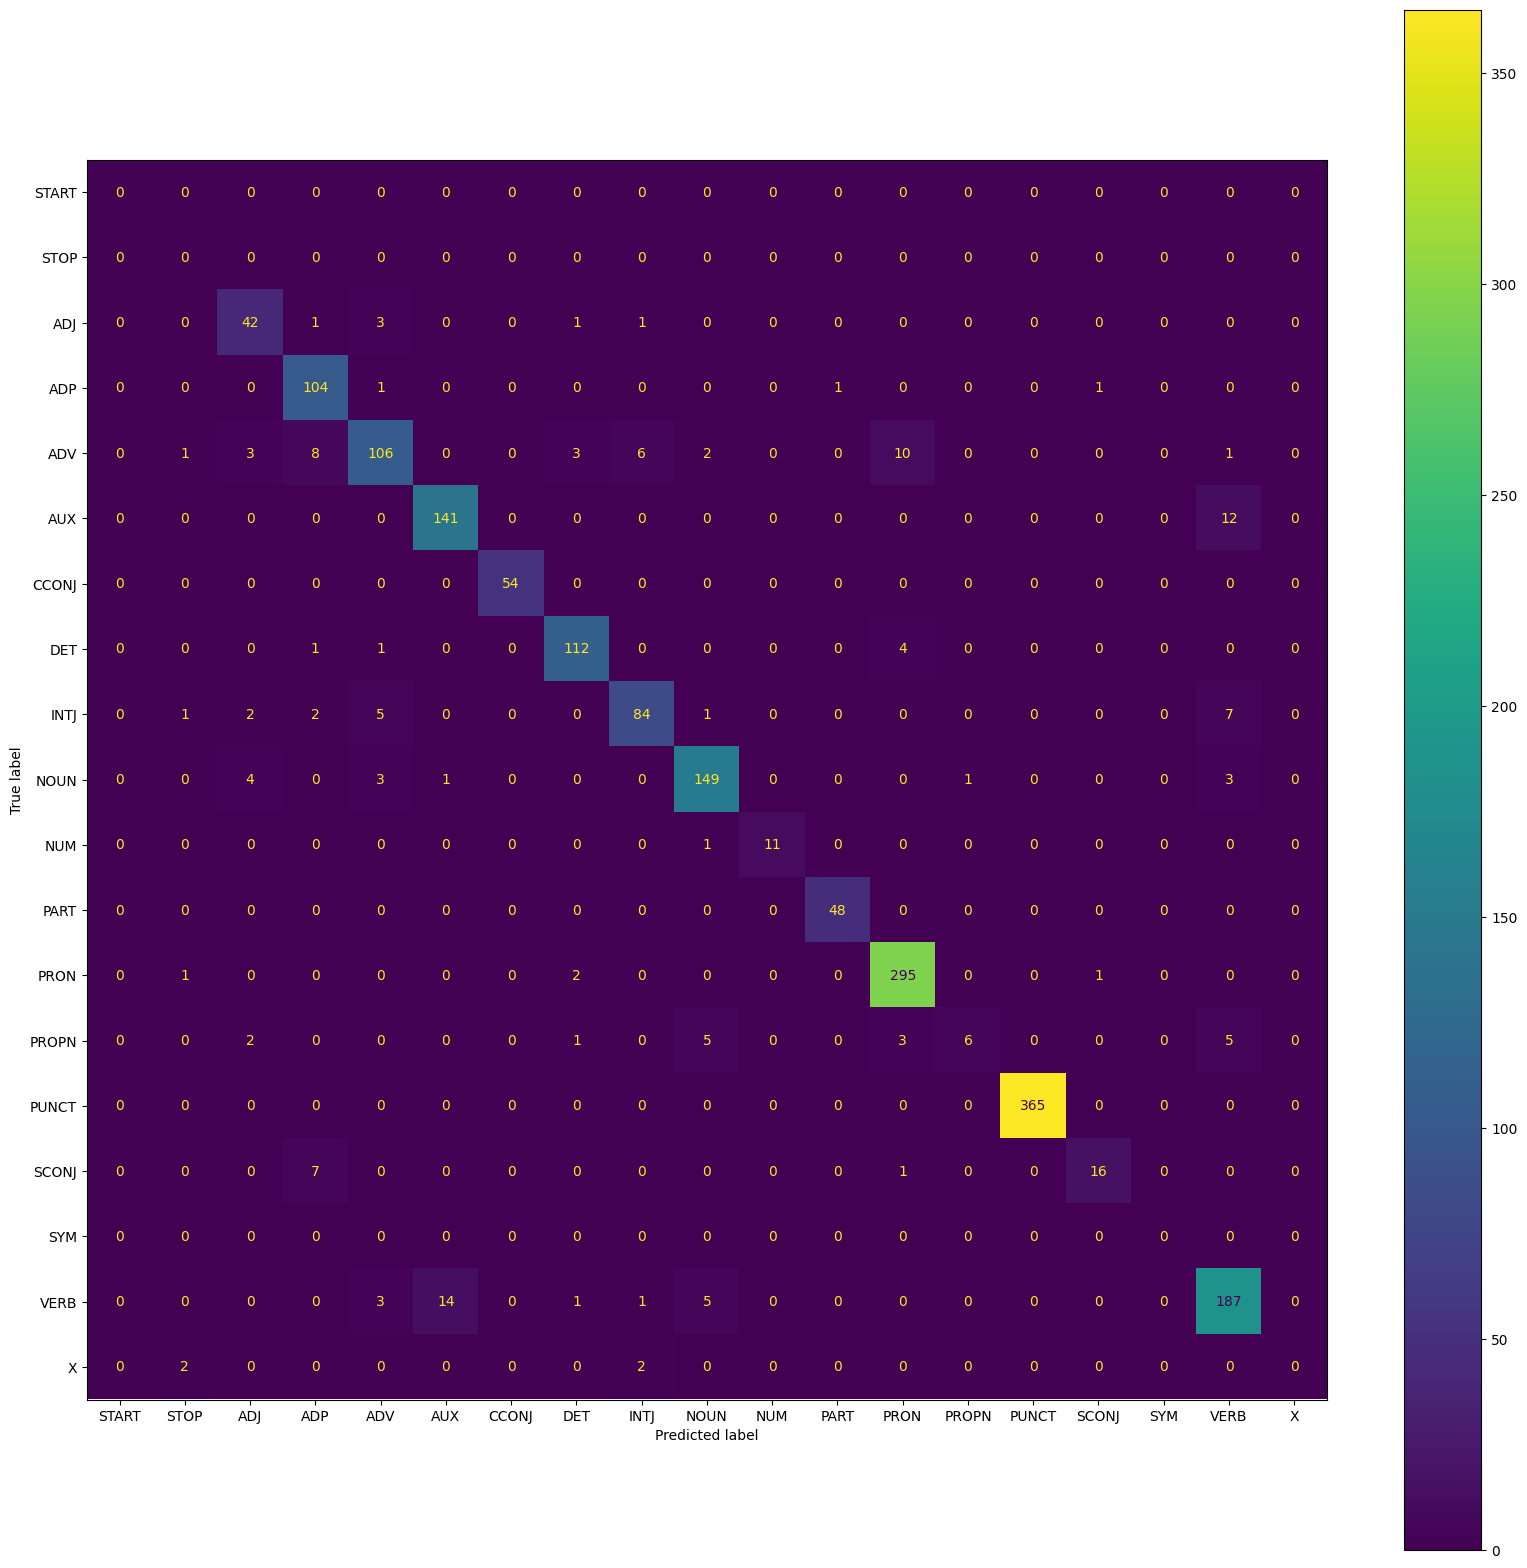

In [94]:
_ , _ = evaluate(isGUM=True, domain="GUM_conversation", show_data=True)

              precision    recall  f1-score   support

         ADJ     0.7132    0.8519    0.7764       108
         ADP     0.8783    0.9951    0.9330       203
         ADV     0.8378    0.7561    0.7949        41
         AUX     0.8800    0.9888    0.9312        89
       CCONJ     1.0000    0.9434    0.9709        53
         DET     0.8389    0.9944    0.9100       178
        INTJ     0.0000    0.0000    0.0000         0
        NOUN     0.6667    0.8207    0.7357       329
         NUM     0.9487    0.7400    0.8315        50
        PART     0.6667    0.9231    0.7742        39
        PRON     0.7326    0.9844    0.8400        64
       PROPN     0.9391    0.3283    0.4865       329
       PUNCT     0.9461    1.0000    0.9723       228
       SCONJ     0.7000    0.5385    0.6087        13
        STOP     0.0000    0.0000    0.0000         0
         SYM     0.0000    0.0000    0.0000         0
        VERB     0.9073    0.8204    0.8616       167

    accuracy              

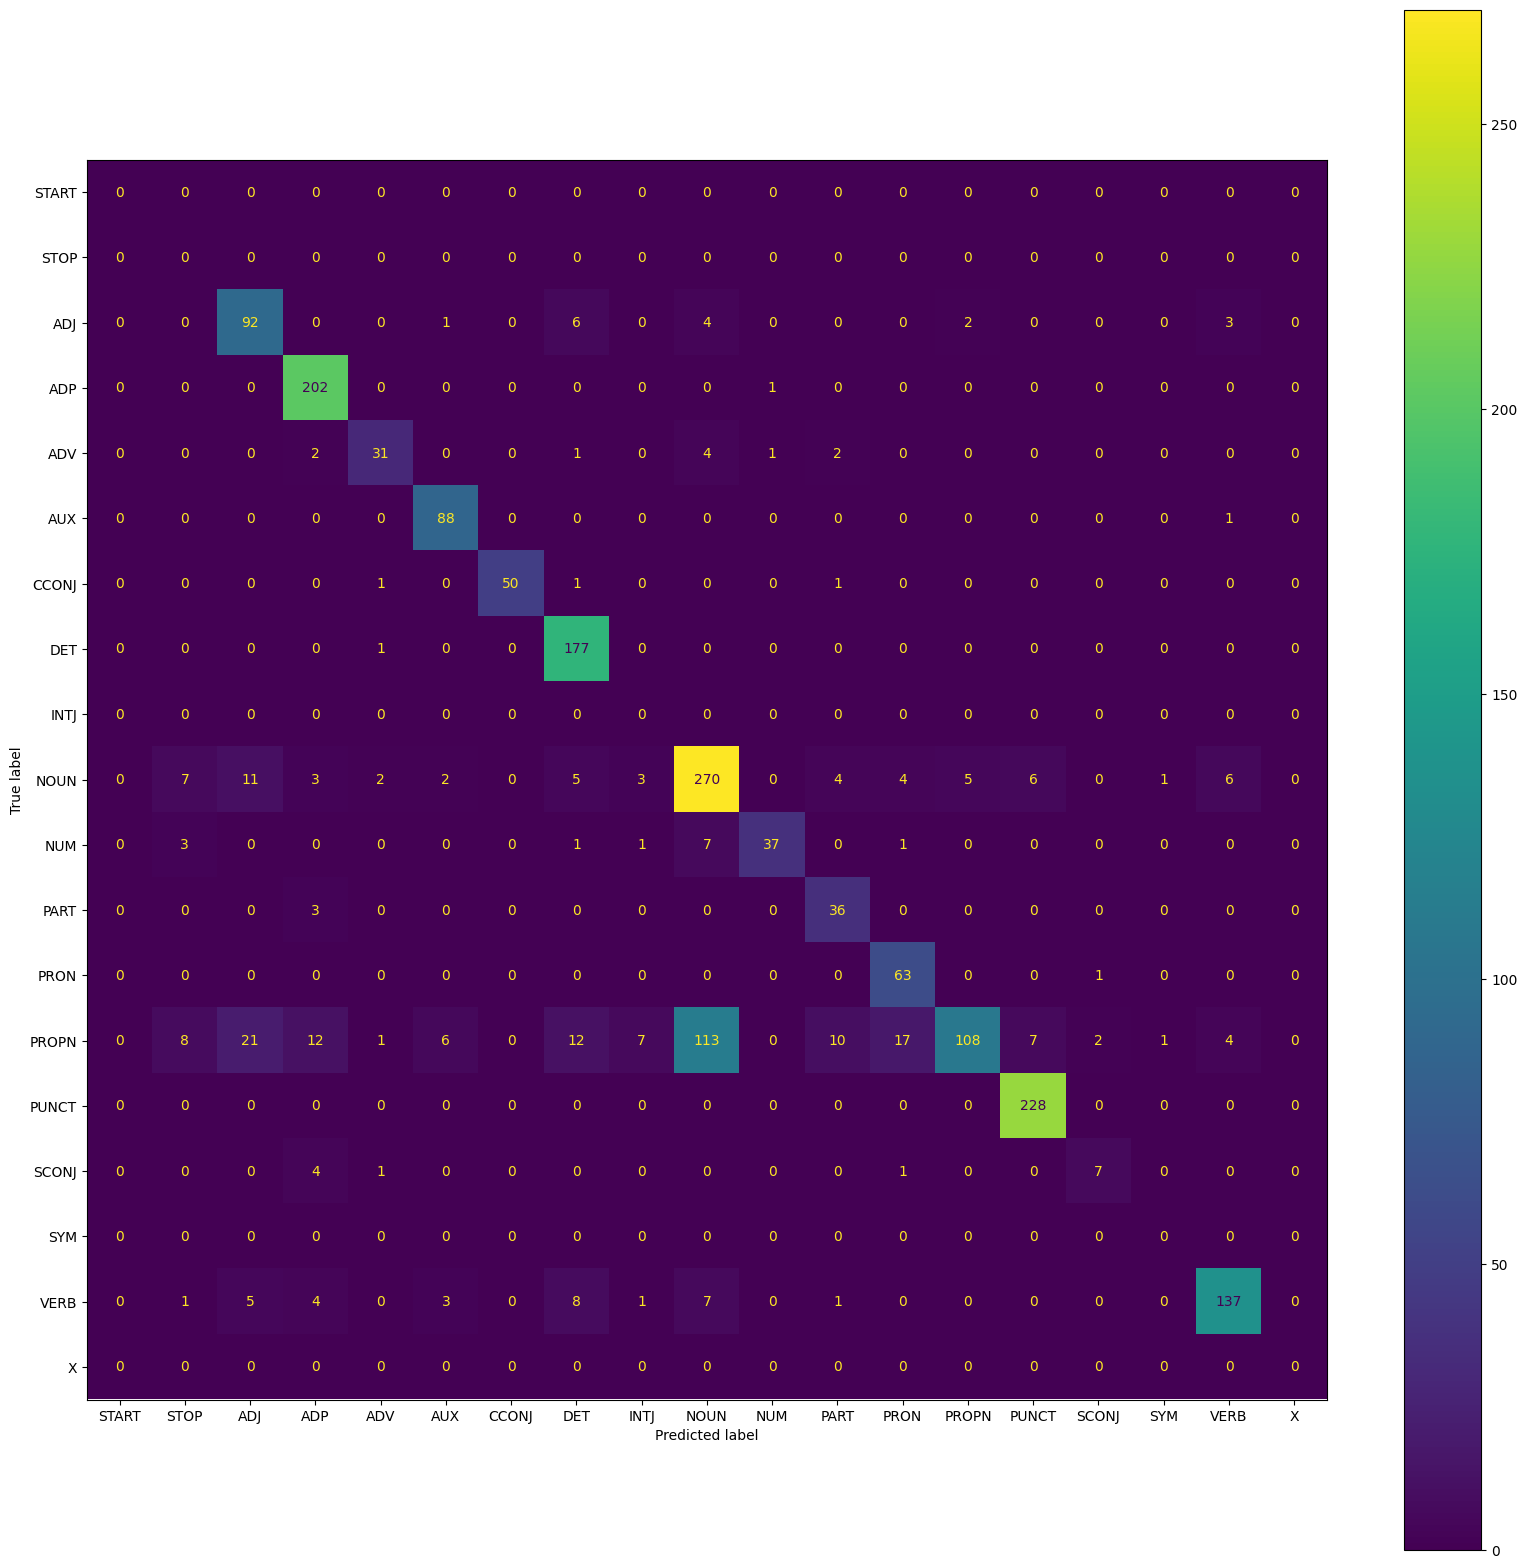

In [95]:
_ , _ = evaluate(isGUM=True, domain="GUM_news", show_data=True)

### Out-of-domain

For the same parameters we had before, let's see how well the model performs over the GENTLE corpus

In [96]:

for domain in doc_type_GENTLE:
    print("----------------------------------------------------------------------------------------------------")
    print(f"-------------------------------------------{domain}------------------------------------------------")
    print("----------------------------------------------------------------------------------------------------")
    mis, tok = evaluate(isGUM=False, domain=domain, show_data=False)
    print("The accuracy for " + str(domain) + " is: " + str(100-(100 * mis/tok)))
    print("####################################################################################################")
    print("####################################################################################################")

----------------------------------------------------------------------------------------------------
-------------------------------------------GENTLE_dictionary------------------------------------------------
----------------------------------------------------------------------------------------------------
The accuracy for GENTLE_dictionary is: 81.39438943894389
####################################################################################################
####################################################################################################
----------------------------------------------------------------------------------------------------
-------------------------------------------GENTLE_esports------------------------------------------------
----------------------------------------------------------------------------------------------------
The accuracy for GENTLE_esports is: 84.9232201023732
#####################################################################

The model is able to perform reasonably well on very specific domains (it gets closes to 90% accuracy on Esports commentary and Deah threats), however, the more specific a domain is, the worse it performs. By the point it gets to Mathematical proofs, it has a meager 70% accuracy.

Once again, lets see all the data from the best performing and worst performing domains.

              precision    recall  f1-score   support

         ADJ     0.7196    0.6814    0.7000       113
         ADP     0.9231    0.9626    0.9424       187
         ADV     0.7667    0.8440    0.8035       109
         AUX     0.8368    0.9578    0.8933       166
       CCONJ     1.0000    0.9848    0.9924        66
         DET     0.9156    0.9658    0.9400       146
        INTJ     0.5000    0.2174    0.3030        23
        NOUN     0.8617    0.8246    0.8428       325
         NUM     1.0000    0.6786    0.8085        28
        PART     0.8736    1.0000    0.9325        76
        PRON     0.9538    0.9792    0.9663       337
       PROPN     0.6296    0.3400    0.4416        50
       PUNCT     0.9630    1.0000    0.9811       182
       SCONJ     0.7941    0.5870    0.6750        46
        STOP     0.0000    0.0000    0.0000         0
         SYM     0.0000    0.0000    0.0000         1
        VERB     0.8873    0.8750    0.8811       288
           X     0.5000    

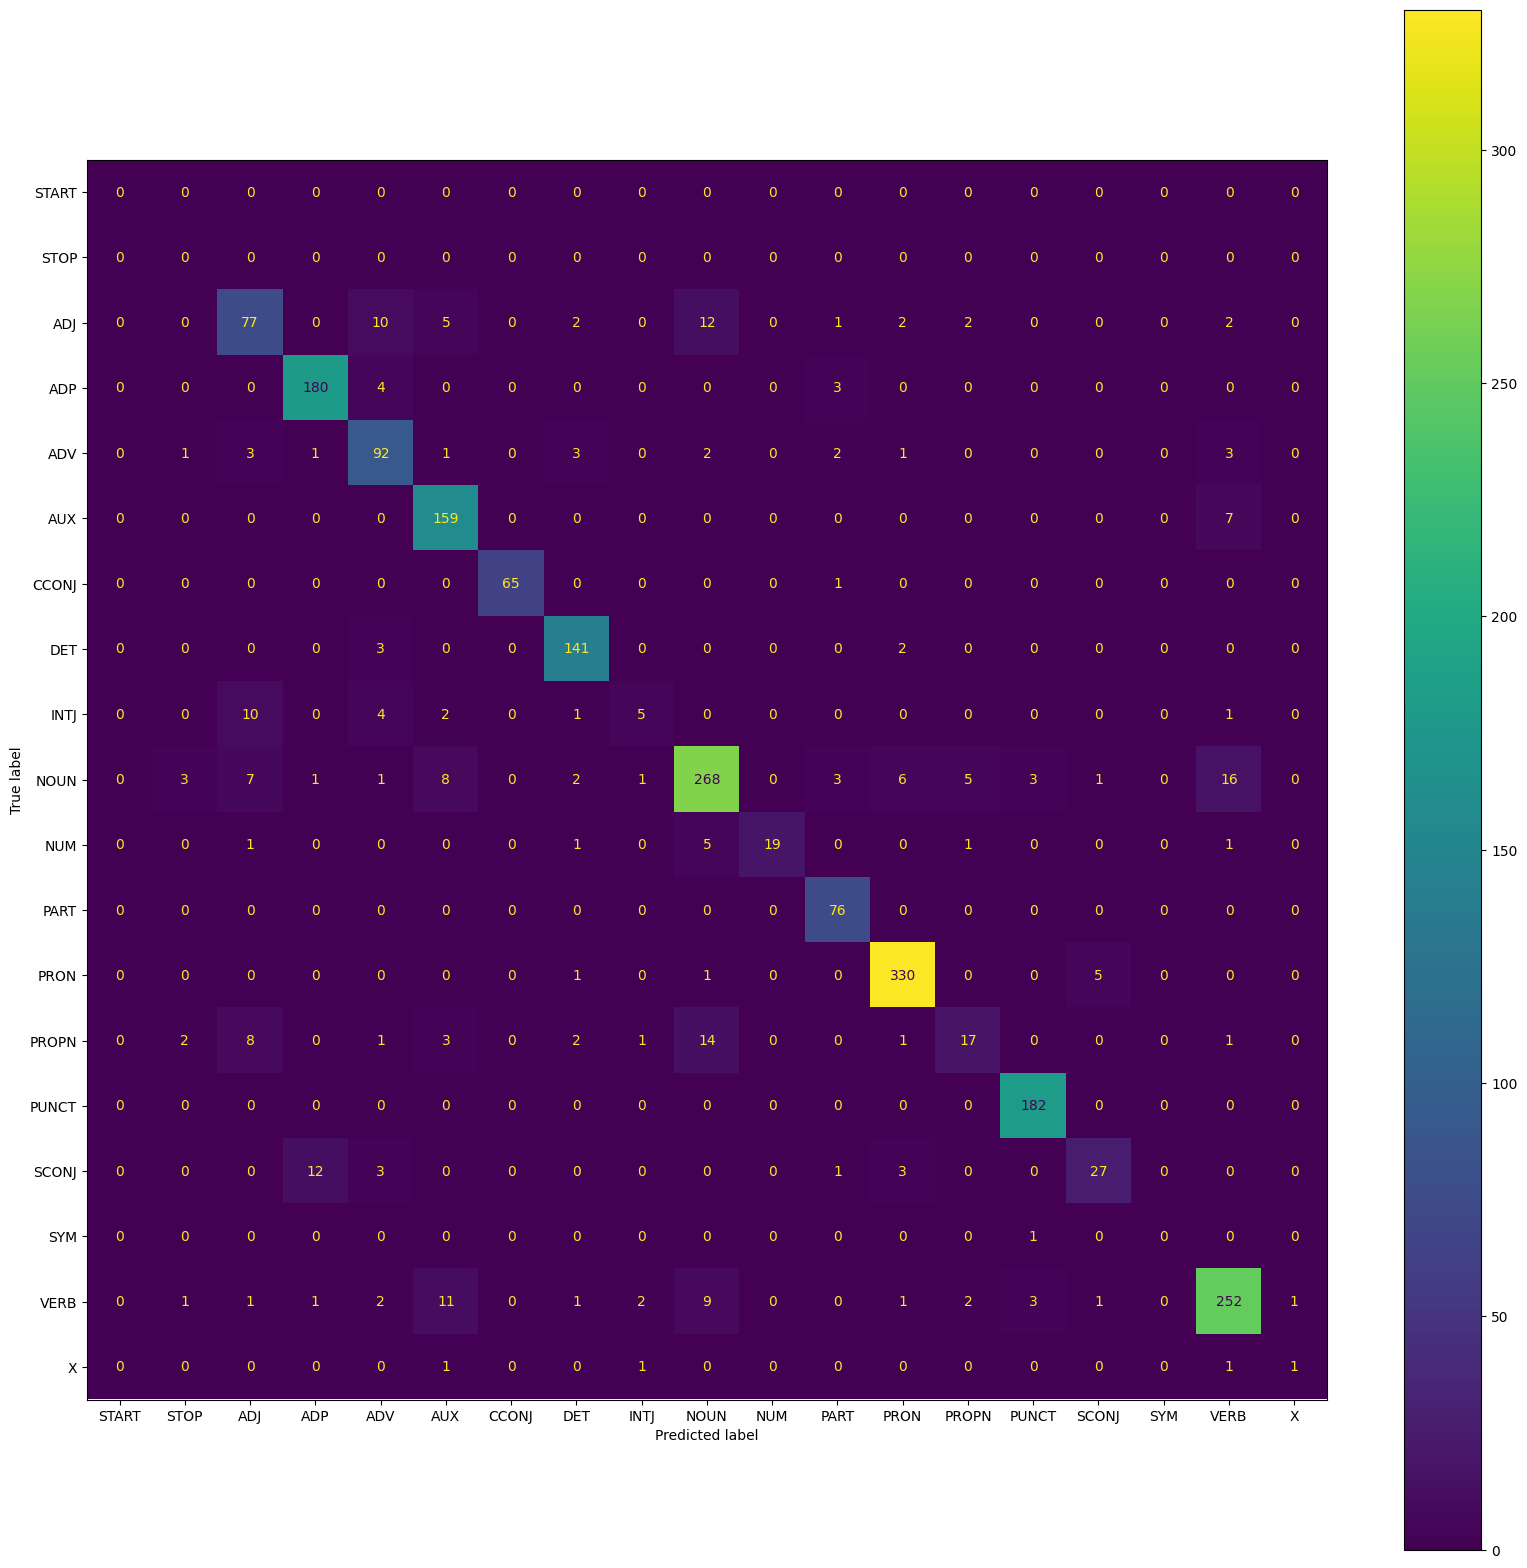

In [97]:
_ , _ = evaluate(isGUM=False, domain="GENTLE_threat", show_data=True)

              precision    recall  f1-score   support

         ADJ     0.6121    0.5379    0.5726       132
         ADP     0.8263    0.9466    0.8824       206
         ADV     0.8526    0.7570    0.8020       107
         AUX     0.8462    1.0000    0.9167       110
       CCONJ     1.0000    0.9661    0.9828        59
         DET     0.6566    0.9909    0.7899       110
        INTJ     0.0000    0.0000    0.0000         0
        NOUN     0.8281    0.4684    0.5983       617
         NUM     0.6296    0.6538    0.6415        52
        PART     0.4545    1.0000    0.6250        10
        PRON     0.4130    1.0000    0.5846        57
       PROPN     0.0123    0.0250    0.0165        40
       PUNCT     0.9164    0.9867    0.9502       300
       SCONJ     0.9032    0.5957    0.7179        47
       START     0.0000    0.0000    0.0000         0
        STOP     0.0000    0.0000    0.0000         0
         SYM     0.9231    0.1905    0.3158       126
        VERB     0.7081    

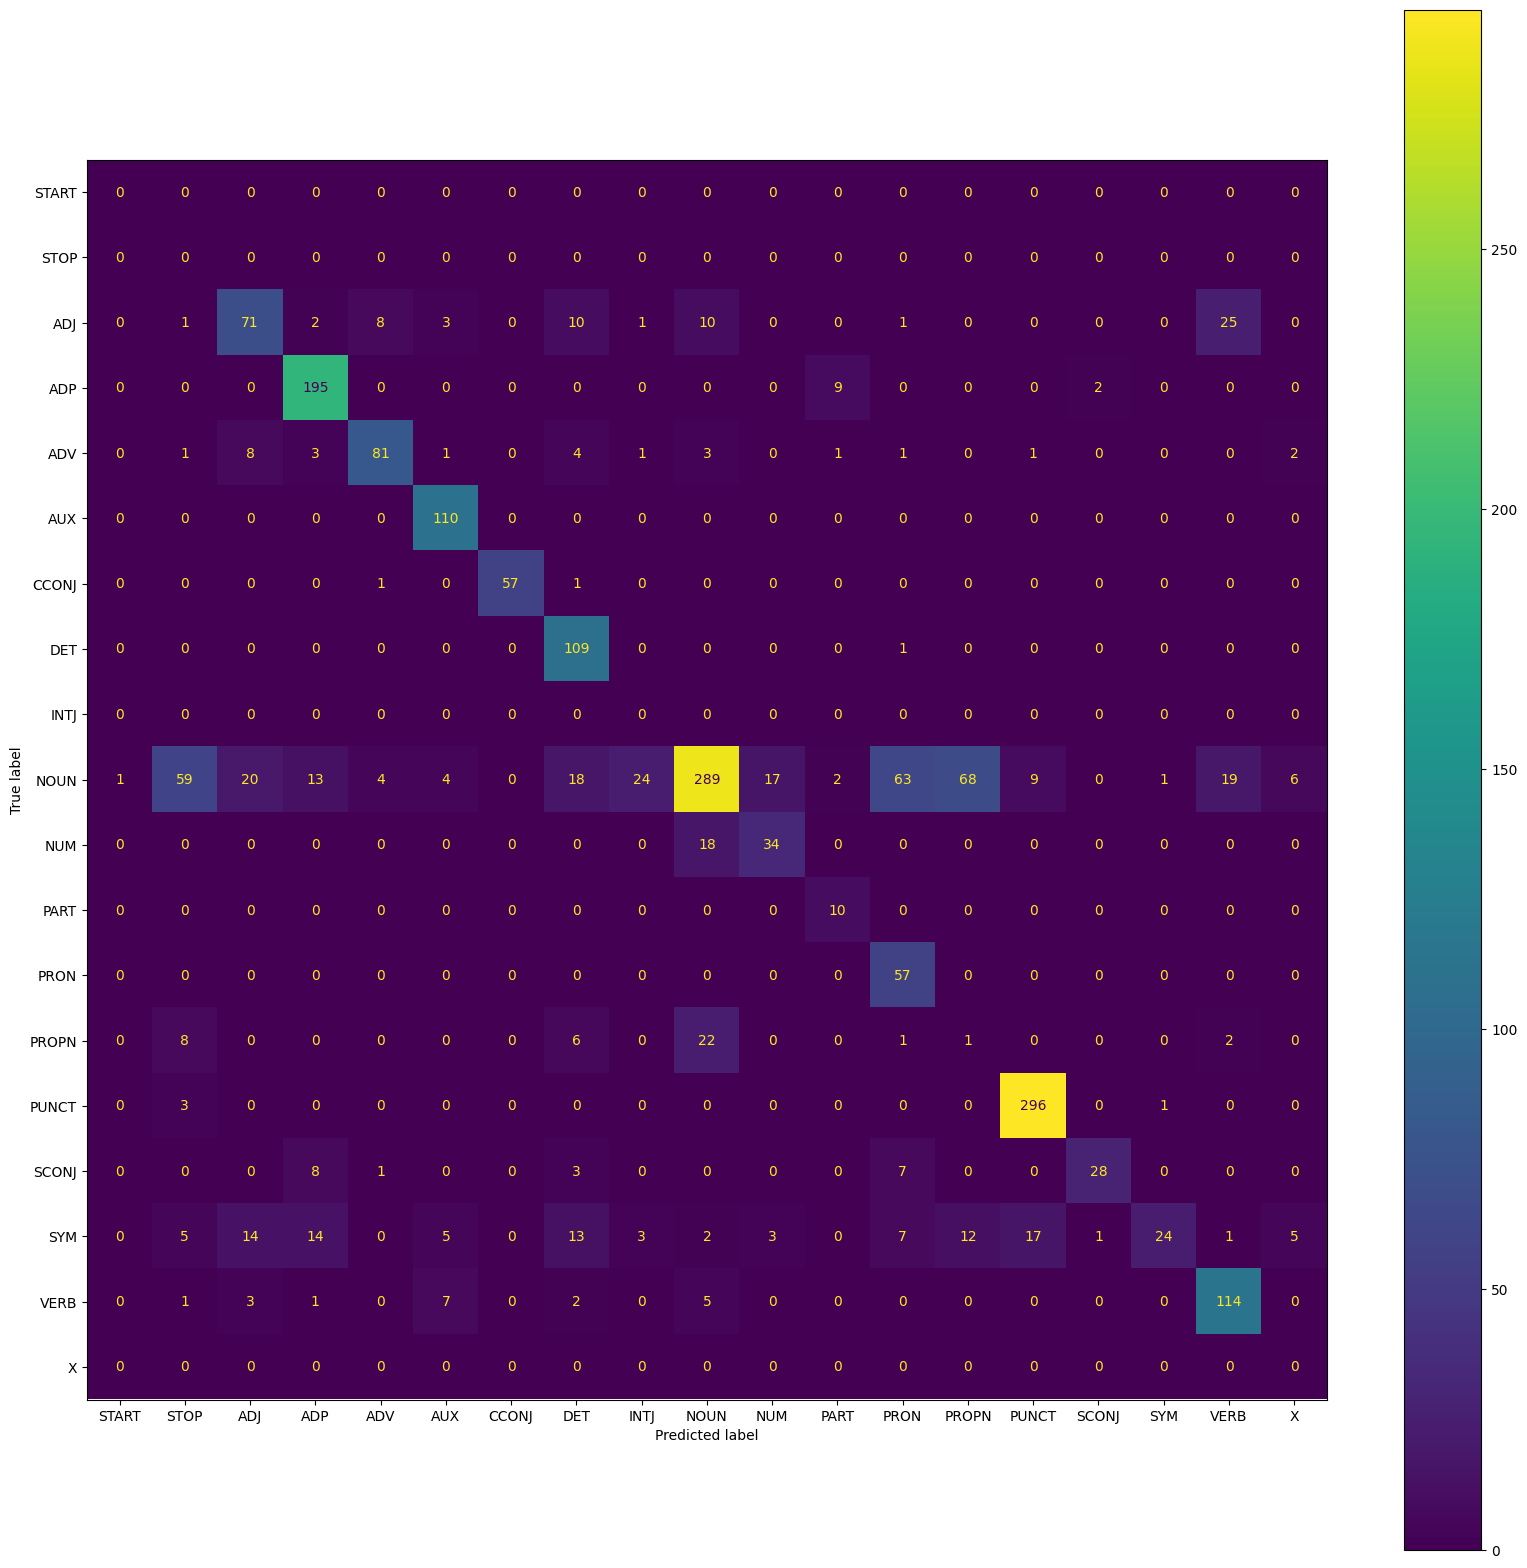

In [98]:
_ , _ = evaluate(isGUM=False, domain="GENTLE_proof", show_data=True)

In addition, data will be retrieved from "Mastodon" social media to further analyze the performance of the model:

Username: nagorebravo
Password: KNdc3/u93^ipn4i

In [ ]:
query = ['politics'] # any topic

In [ ]:
def server_query(num, q, limit):
  serv = None
  if num == 0:
    serv = f"https://mastodon.social/api/v1/timelines/tag/{q}?limit={limit}"
  elif num == 1:
    serv = f"https://mstdn.social/api/v1/timelines/tag/{q}?limit={limit}"
  elif num == 2:
    serv = f"https://mastodon.world/api/v1/timelines/tag/{q}?limit={limit}"
  elif num == 3:
    serv = f"https://mas.to/api/v1/timelines/tag/{q}?limit={limit}"
  elif num == 4:
    serv = f"https://mastodon.online/api/v1/timelines/tag/{q}?limit={limit}"
  return serv


In [ ]:
limit = 100 # max
df_data_not_processed = pd.DataFrame()

idsList = []
data = []
for q in query:
	for i in range(5): #0tik 4ra, zerbitzari guztiak errekorritzeko
		query_string = server_query(i, q, limit)
		response = requests.get(query_string)
		for res in response.json():
			c = bs(res["content"], features="html5lib")
			text = c.getText()
			if res["id"] not in idsList and res["language"]=='en': #or res["language"]=='es'):  <-- HIZKUNTZA: ingelesa nahi dugu
				idsList.append(res["id"])
				json_obj = {"id": res["id"], "name": res["account"]["username"], "lang": res["language"], "text": text}
				data.append(json_obj)

df1 = pd.DataFrame.from_dict(data) # >>> 900
df_data_not_processed = pd.concat([df_data_not_processed, df1])


In [ ]:
print(len(df_data_not_processed))
df_data_not_processed.head(100)

In [ ]:
df_data_not_processed.to_excel('datuak.xlsx')

Once the data is annotated...

In [ ]:
df_data_annotated = pd.read_excel('NAME_OF_EXCEL')

## Conclusion